# Clasificador de Fake News con técnicas de procesamiento del lenguaje natural

Con el avance del internet y la globalización, las noticias pueden divulgase con mayor rapidez, tanto las reales como las falsas. Para solucionár el avance de las noticias falsas, se propone desarrollar un modelo de Aprendizaje Automático que mediante el uso de Procesamiento del Lenguaje Natural (PLN), detecte si una noticia es falsa.

### Módulos

Los módulos utilizados en el desarrollo serán las siguientes

In [58]:
# Manejo de datos
import pandas as pd
import numpy as np
# Procesos de Procesamiento del Lenguaje Natural
import nltk
nltk.download('punkt')
from nltk import regexp_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
# descarga de lista de palabras de spacy en español
!python -m spacy download es_core_news_sm
import spacy
nlp= spacy.load('es_core_news_sm')
import re
from sklearn.feature_extraction.text import TfidfVectorizer
# Módulos para el entrenamiento de modelos y preparación de datos
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Modelos de aprendizaje automatico
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# Módulo para la evaluacion del modelo planteado
from sklearn.metrics import confusion_matrix, accuracy_score
# Modulo para presentar graficas
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Guardado de modelos
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     --------------------------------------- 0.0/12.9 MB 217.9 kB/s eta 0:01:00
     --------------------------------------- 0.1/12.9 MB 328.2 kB/s eta 0:00:40
     --------------------------------------- 0.1/12.9 MB 561.1 kB/s eta 0:00:23
      -------------------------------------- 0.2/12.9 MB 765.3 kB/s eta 0:00:17
     - ------------------------------------- 0.3/12.9 MB 982.3 kB/s eta 0:00:13
     - -------------------------------------- 0.5/12.9 MB 1.3 MB/s eta 0:00:10
     -- ------------------------------------- 0.7/12.9 MB 1.5 MB/s eta 0:00:09
     -- ------------------------------------- 0.8/12.9 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.9/12.9 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.9/12.9 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.9/12.9 MB 1.4

### Data Sets

Los datos fueron extraidos desde [Kaggle](https://www.kaggle.com/datasets/arseniitretiakov/noticias-falsas-en-espaol), donde para el entrenamiento del modelo se utilizarán las 1000 noticias verdaderas y 1000 falsas, sin procesár el título del articulo. 

Una vez cargadas las noticias, se identificarán a las noticias verdaderas como 0, mientras que las noticias falsas se identificarán con 1. Una vez generada esta distinción, se unirán las dos tablas, generando así el set de datos que se utilizará para la creación del modelo. 

In [59]:
# Importación de 1000 noticias clasificadas como verdaderas
df_solo_verdaderas= pd.read_csv('onlytrue1000.csv')
# Generación de variable categorica para identificar cuando una noticia es verdadera
df_solo_verdaderas['clase']= 0
# Importación de 1000 noticias clasificadas como falsas
df_solo_falsas= pd.read_csv('onlyfakes1000.csv')
# Generación de variable categorica para identificar cuando una noticia es falsa
df_solo_falsas['clase']= 1
###############################
# Union de los dos set de datos
df_fake_news = pd.concat([df_solo_verdaderas, df_solo_falsas]).reset_index(drop=True)
# Mezclado de los datos para eliminar el orden que tienen los datos
df_fake_news=shuffle(df_fake_news)
# La variable clase será una categoria, por lo que se le cambia de tipo de dato
df_fake_news['clase']= df_fake_news['clase'].astype('category')
# Visualización de datos
df_fake_news.head()

,text,clase
1343,El viral de los bomberos de Croacia forma part...,1
453,El PSOE recurrirá un error en el recuento de v...,0
1084,5 de los 9 jueces votaron que la Sharia o cual...,1
283,Donald Trump se revolvió con furia este miérco...,0
429,El PP no se sentará con Vox antes de cerrar lo...,0


### Función de preprocesamiento

Para facilitár y agilizár el procesamiento de los diferentes textos, se genera una función que contiene las tecnicas de Procesamiento del Lenguaje Natural a realizar. Esta transformará el texto a clasificár, y devolverá un string que contendrá los tokens necesarios, en este caso palabras, filtrando las palabras que no aportan información (Stop Words), y ademas lematizando las palabras, generando así que se reduzca la cantidad de palabras que representa a cada artículo.

In [60]:
# Establecemos la lista de stop words en español 
stops= set(stopwords.words('spanish'))
def preprocesamiento(documento):
# Eliminación de valores numéricos
  documento = re.sub('\d', ' ', documento)
# Minusculizamos todos los textos y palabras, así si entra una palabra con mayuscula, no se la tomará como si fuese otra palabra
  documento = documento.lower()
############################## TOKENIZAR ##############################
# Tokenizo con una List Comprehension, y luego a esta le filtro las stopwords
  tokenizado = [token for token in regexp_tokenize(documento, pattern='\w+')]
  filtro = [filtro for filtro in tokenizado if filtro not in stops]
############################## LEMATIZAR ##############################
# Spacy tiene su propio tokenizador 
  doc= nlp(documento)
# Lematizo al texto, para eliminár los signos de puntuación o demas signos que no me aportarán al análisis, se filtrarán los tokens
# que están en la anterior List Comprehension llamada filtro
  lemma = [lema.lemma_ for lema in doc if str(lema) in filtro]
  # transformo mi lista de tokens a una cadena de texto
  Procesada=" ".join(map(str, lemma))
  return Procesada

### Preparación de datos 

In [61]:
# Dividimos los datos en features y target
x= df_fake_news['text'].apply(preprocesamiento)
y=df_fake_news['clase']
# División de datos para entrenar y testear el modelo
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,random_state=123)

#### Generación de vector TF-IDF

Generamos un vector TF-IDF con la frecuencia de cada token en todos los documentos. Este set de datos serán las variables para entrenar y testear mi modelo de Aprendizaje Automatico.

In [62]:
# Creación de TF-IDF 
vectorizer = TfidfVectorizer()
# Entrenamiento del vector y converción de los datos de x_train en el vector TF-IDF
x_train = vectorizer.fit_transform(x_train).toarray()
# Conversión de datos para testear
x_test= vectorizer.transform(x_test).toarray()
# Generación de set de datos con la información de TF-IDF para los datos de entrenar y testear
nombres= vectorizer.get_feature_names_out()
# Set de datos para entrenar
x_train= pd.DataFrame(x_train,columns=nombres )
# Set de datos para testear
x_test= pd.DataFrame(x_test,columns=nombres )

### Gráficos

Se presentarán una serie nubes de palabras que indicarán la mayor cantidad de veces que se repiten cada una, identificando cuáles son los tokens que aparecen mas veces en la totalidad de articulos, en las noticias verdaderas como así tambien en las noticias falsas.

#### Palabras mas usadas en todo el set de datos

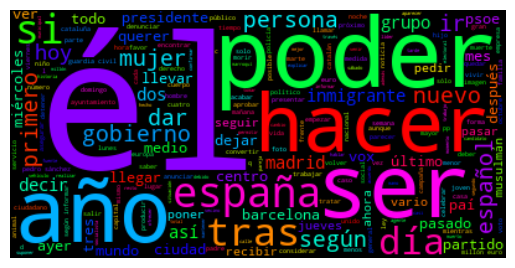

In [63]:
todas_palabras = " ".join([palabra for palabra in x])
wc = WordCloud(background_color = "black",colormap = "hsv", max_font_size = 150, random_state = 123).generate(todas_palabras)
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

En la anterior nube de palabras se puede observar que la palabra que mas se repite en todos los articulos es el pronombre él, seguidos por poder, hacer y ser. Este grafico no nos aporta mucha información, ya que analiza tanto noticias verdaderas como falsas. Seria mas revelador observar el comportamiento que ocurre en cada categoría.

In [64]:
# Concatenación de tokens con categoría
df_Grafico= pd.DataFrame()
df_Grafico['Token']= x
df_Grafico['clase']=y

#### Palabras mas usadas en noticias verdaderas

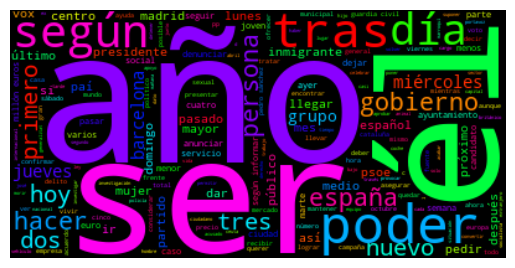

In [65]:
Palabras_Verdaderas = " ".join([palabra for palabra in df_Grafico['Token'][df_Grafico['clase']==0]])
wc = WordCloud(background_color = "black",colormap = "hsv", max_font_size = 150, random_state = 123).generate(Palabras_Verdaderas)
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

En la anterior nube de palabras se puede observar que la palabra que mas se repite en todos los articulos clasificados como verdaderos es también el pronombre él, seguidos por año y ser.

#### Palabras mas usadas en noticias falsas

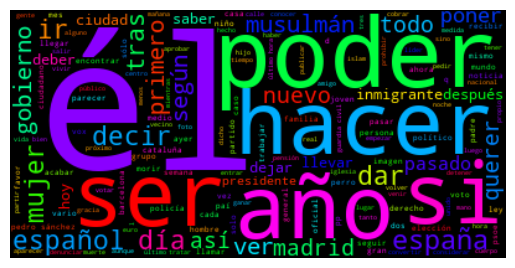

In [66]:
Palabras_Falsas = " ".join([palabra for palabra in df_Grafico['Token'][df_Grafico['clase']==1]])
wc = WordCloud(background_color = "black",colormap = "hsv", max_font_size = 150, random_state = 123).generate(Palabras_Falsas)
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

En la anterior nube de palabras se puede observar que la palabra que mas se repite en todos los articulos clasificados como falsos es también el pronombre él, seguidos por poder, ser, hacer o año.

##### Se puede observar que la palabra él no aportará información, por lo que se podría analizar sacarla 

### Modelos de ML

#### SVM

In [103]:
# Creación del modelo
svc= SVC(random_state=123)
# Selección de hiperparametros
param_grid_svc = {'C':[1.4,1.43,1.44], 'gamma':['scale']}
# Con el uso de cross validation se probarán las distintas combinaciones de hiperparametros
gscv_svc = GridSearchCV(svc,param_grid=param_grid_svc, scoring='accuracy',cv=5,verbose=0,refit=True)
# Entrenamiento de Grid Search
gscv_svc.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=123),
             param_grid={'C': [1.4, 1.43, 1.44], 'gamma': ['scale']},
             scoring='accuracy')

#### Random Forest

In [78]:
# Creación del modelo
RandomForest= RandomForestClassifier(random_state=123)
# Selección de hiperparametros
param_grid_RForest = {'n_estimators':[250,300,350], 'criterion':['gini'], 'max_depth':[95,100,105]}
# Con el uso de cross validation se probarán las distintas combinaciones de hiperparametros
gscv_RForest = GridSearchCV(RandomForest,param_grid=param_grid_RForest, scoring='accuracy',cv=5,verbose=0,refit=True)
# Entrenamiento de Grid Search
gscv_RForest.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             param_grid={'criterion': ['gini'], 'max_depth': [95, 100, 105],
                         'n_estimators': [250, 300, 350]},
             scoring='accuracy')

#### K Neighbors Classifier¶

In [70]:
# Creación del modelo
KNN= KNeighborsClassifier()
# Selección de hiperparametros
param_grid_KNN = {'n_neighbors':[100,300,500], 'weights':['uniform','distance']}
# Con el uso de cross validation se probarán las distintas combinaciones de hiperparametros
gscv_KNN = GridSearchCV(KNN,param_grid=param_grid_KNN, scoring='accuracy',cv=5,verbose=0,refit=True)
# Entrenamiento de Grid Search
gscv_KNN.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [100, 300, 500],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

### Mejor modelo

In [104]:
print("Accuracy SVM: ",gscv_svc.best_score_,' +/- ', 2*gscv_svc.cv_results_['std_test_score'][gscv_svc.best_index_], '( 95% )')
print("Accuracy Random Forest: ",gscv_RForest.best_score_,' +/- ', 2*gscv_RForest.cv_results_['std_test_score'][gscv_RForest.best_index_], '( 95% )')
print("Accuracy SVM: ",gscv_KNN.best_score_,' +/- ', 2*gscv_KNN.cv_results_['std_test_score'][gscv_KNN.best_index_], '( 95% )')

Accuracy SVM:  0.7768750000000001  +/-  0.0411931426332102 ( 95% )
Accuracy Random Forest:  0.7306250000000001  +/-  0.04319288135792748 ( 95% )
Accuracy SVM:  0.703125  +/-  0.0452424026771346 ( 95% )


In [105]:
# Hiperparametros que dieron mejores resultados con SVM
gscv_svc.best_params_

{'C': 1.44, 'gamma': 'scale'}

Se puede observar que el mejor modelo es el de Máquinas de Vectores de Soporte (SVM), por ende se utilizará para generar el modelo de producción con la combinación de hiperparametros que dió los mejores resultados de accuracy.

### Modelo de producción

El valor del Accuracy del modelo es igual a 0.795


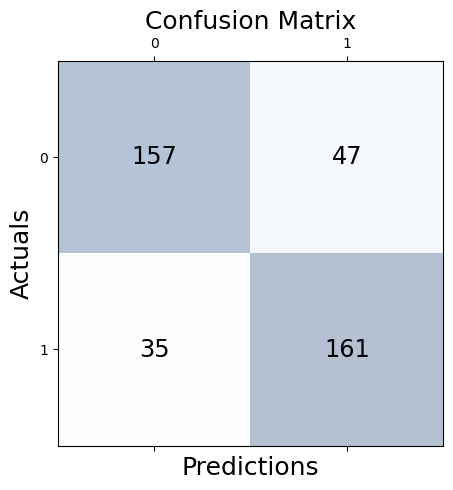

In [106]:
# Creación del modelo con los mejores valores de hiperparametro
svc_final= SVC(random_state=123, C=1.44, gamma='scale')
# Entrenamiento de Grid Search
svc_final.fit(x_train, y_train)
# Predicción de valores 
y_pred = svc_final.predict(x_test)
# Generación de accuracy del modelo 
AC = accuracy_score(y_test, y_pred)
# Matriz de confusión
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
print(f'El valor del Accuracy del modelo es igual a {AC}')
plt.show()

De la matriz de confución, se puede observar que en un 77% de las observaciones que se predijeron como falsas se clasificaron de manera correcta, mientras que solo 23% de ellas fueron clasificadas incorrectamente. Por otro lado, un 82% de las noticias que eran verdaderas fueron clasificadas correctamente, mientras que un 18% de los casos fue identificada de forma incorrecta.

### Modelo de producción

In [111]:
# Convertimos los valores de x como un vector TF-IDF
x= vectorizer.transform(x).toarray()
# Entrenamos el modelo con todos los valores de x e y
svc_final.fit(x,y)
# Guardamos el modelo entrenado para luego utilizarlo
pickle.dump(svc_produccion, open('modelo_produccion.p', 'wb'))